# D7059E

*   Jacob Yousif
*   Donato Scarano


## Importing libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%%capture
!pip install torch -U accelerate -U transformers seaborn

In [3]:
%%capture
import os
import pandas as pd
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_score

from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from transformers import EarlyStoppingCallback
from scipy.special import softmax

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
%%capture
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [5]:
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels.astype(np.float32)

    def __getitem__(self, idx):
        return {"input_ids": self.texts[idx], "labels": self.labels[idx]}

    def __len__(self):
        return len(self.labels)


In [6]:
def tokenize_texts(texts):
    return tokenizer(texts, padding="max_length", truncation=True, max_length=512, return_tensors="pt").input_ids

## Data Loading

In [7]:
file_path = 'datasets/PreprocessedLiteratureAs15SentenceSegments.csv'
df = pd.read_csv(file_path)

In [8]:
df = df.dropna().reset_index(drop=True)
main = df.copy()

In [9]:
authors = df.groupby('AuthorCode').agg(SegmentCount=('AuthorCode', 'size'), Author=('Author', 'first')).reset_index()

In [10]:
plots_dir = 'b/16/'

In [11]:
print('The length of the dataset is:', str(len(df)))

The length of the dataset is: 28842


In [12]:
has_nan = df.isnull().values.any()
print(f"Are there any NaN values in the DataFrame? {has_nan}")

Are there any NaN values in the DataFrame? False


In [13]:
print(f"Does the DataFrame have any NaN values? {df.isna().sum().sum()}")

Does the DataFrame have any NaN values? 0


### Pre-defined Setup

In [14]:
def write(file_name, latex_table):
    with open(file_name, 'w') as f:
        f.write(latex_table)

In [15]:
input_ids = tokenize_texts(df['Text'].tolist())
labels = pd.get_dummies(df['AuthorCode']).values

In [16]:
print("Shape of input_ids:", input_ids.shape)
print("Shape of labels:", labels.shape)

Shape of input_ids: torch.Size([28842, 512])
Shape of labels: (28842, 16)


In [17]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    input_ids, labels, test_size=0.3, random_state=42, stratify=labels
)

In [18]:
test_texts, val_texts, test_labels, val_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

In [19]:
print("Train texts shape:", train_texts.shape)
print("Test texts shape:", test_texts.shape)
print("Train labels shape:", train_labels.shape)
print("Test labels shape:", test_labels.shape)
print("Train labels shape:", val_texts.shape)
print("Test labels shape:", val_labels.shape)

Train texts shape: torch.Size([20189, 512])
Test texts shape: torch.Size([4326, 512])
Train labels shape: (20189, 16)
Test labels shape: (4326, 16)
Train labels shape: torch.Size([4327, 512])
Test labels shape: (4327, 16)


In [20]:
train_dataset = TextDataset(train_texts, train_labels)
val_dataset = TextDataset(val_texts, val_labels)
test_dataset = TextDataset(test_texts, test_labels)

In [21]:
early_stopping = EarlyStoppingCallback(early_stopping_patience=1)

In [22]:
%%capture
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=16, problem_type="multi_label_classification")

In [23]:
training_args = TrainingArguments(
    output_dir='/temp',
    num_train_epochs=3,
    per_device_train_batch_size=12,
    per_device_eval_batch_size=24,
    warmup_steps=50,
    weight_decay=0.01,
    evaluation_strategy='steps',
    eval_steps=50,
    save_steps=50,
    logging_dir='/temp/logs',
    log_level='info',
    logging_strategy='steps',
    logging_steps=50,
    fp16=True,
    gradient_accumulation_steps=2,
    learning_rate=6e-5,
    lr_scheduler_type='polynomial',
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss'
)

In [24]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=lambda p: {
        'accuracy': accuracy_score(np.argmax(p.label_ids, axis=1), np.argmax(p.predictions, axis=1)),
        'recall': recall_score(np.argmax(p.label_ids, axis=1), np.argmax(p.predictions, axis=1), average='macro'),
        'precision': precision_score(np.argmax(p.label_ids, axis=1), np.argmax(p.predictions, axis=1), average='macro'),
        'f1': f1_score(np.argmax(p.label_ids, axis=1), np.argmax(p.predictions, axis=1), average='macro'),
    },
    callbacks=[early_stopping]
)

In [25]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
50,0.413700,0.226659,0.207072,0.080444,0.026799,0.039780
100,0.220900,0.213776,0.207996,0.103023,0.037840,0.052483
150,0.214300,0.204457,0.255604,0.098862,0.032288,0.048564
200,0.190200,0.167481,0.458979,0.279195,0.231954,0.228612
250,0.153200,0.133915,0.614976,0.480707,0.566527,0.450479
300,0.120600,0.097828,0.826901,0.770834,0.753828,0.752356
350,0.091200,0.072226,0.865265,0.811443,0.861329,0.806906
400,0.071900,0.056164,0.905246,0.884569,0.886051,0.881222
450,0.058000,0.050582,0.904553,0.885080,0.909711,0.891957
500,0.050000,0.042711,0.922348,0.909280,0.924776,0.912515


TrainOutput(global_step=700, training_loss=0.12397604380335127, metrics={'train_runtime': 700.3857, 'train_samples_per_second': 86.477, 'train_steps_per_second': 3.602, 'total_flos': 4420821359001600.0, 'train_loss': 0.12397604380335127, 'epoch': 0.8318478906714201})

In [26]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.03105292282998562, 'eval_accuracy': 0.9470764964178414, 'eval_recall': 0.9372862195213547, 'eval_precision': 0.9472775195311922, 'eval_f1': 0.9413376039681971, 'eval_runtime': 23.6793, 'eval_samples_per_second': 182.733, 'eval_steps_per_second': 7.644, 'epoch': 0.8318478906714201}


In [27]:
test_results = trainer.predict(test_dataset)
predictions = np.argmax(test_results.predictions, axis=-1)

In [28]:
from sklearn.preprocessing import label_binarize
one_hot_predictions = label_binarize(predictions, classes=np.arange(len(np.unique(test_labels.argmax(axis=1)))))

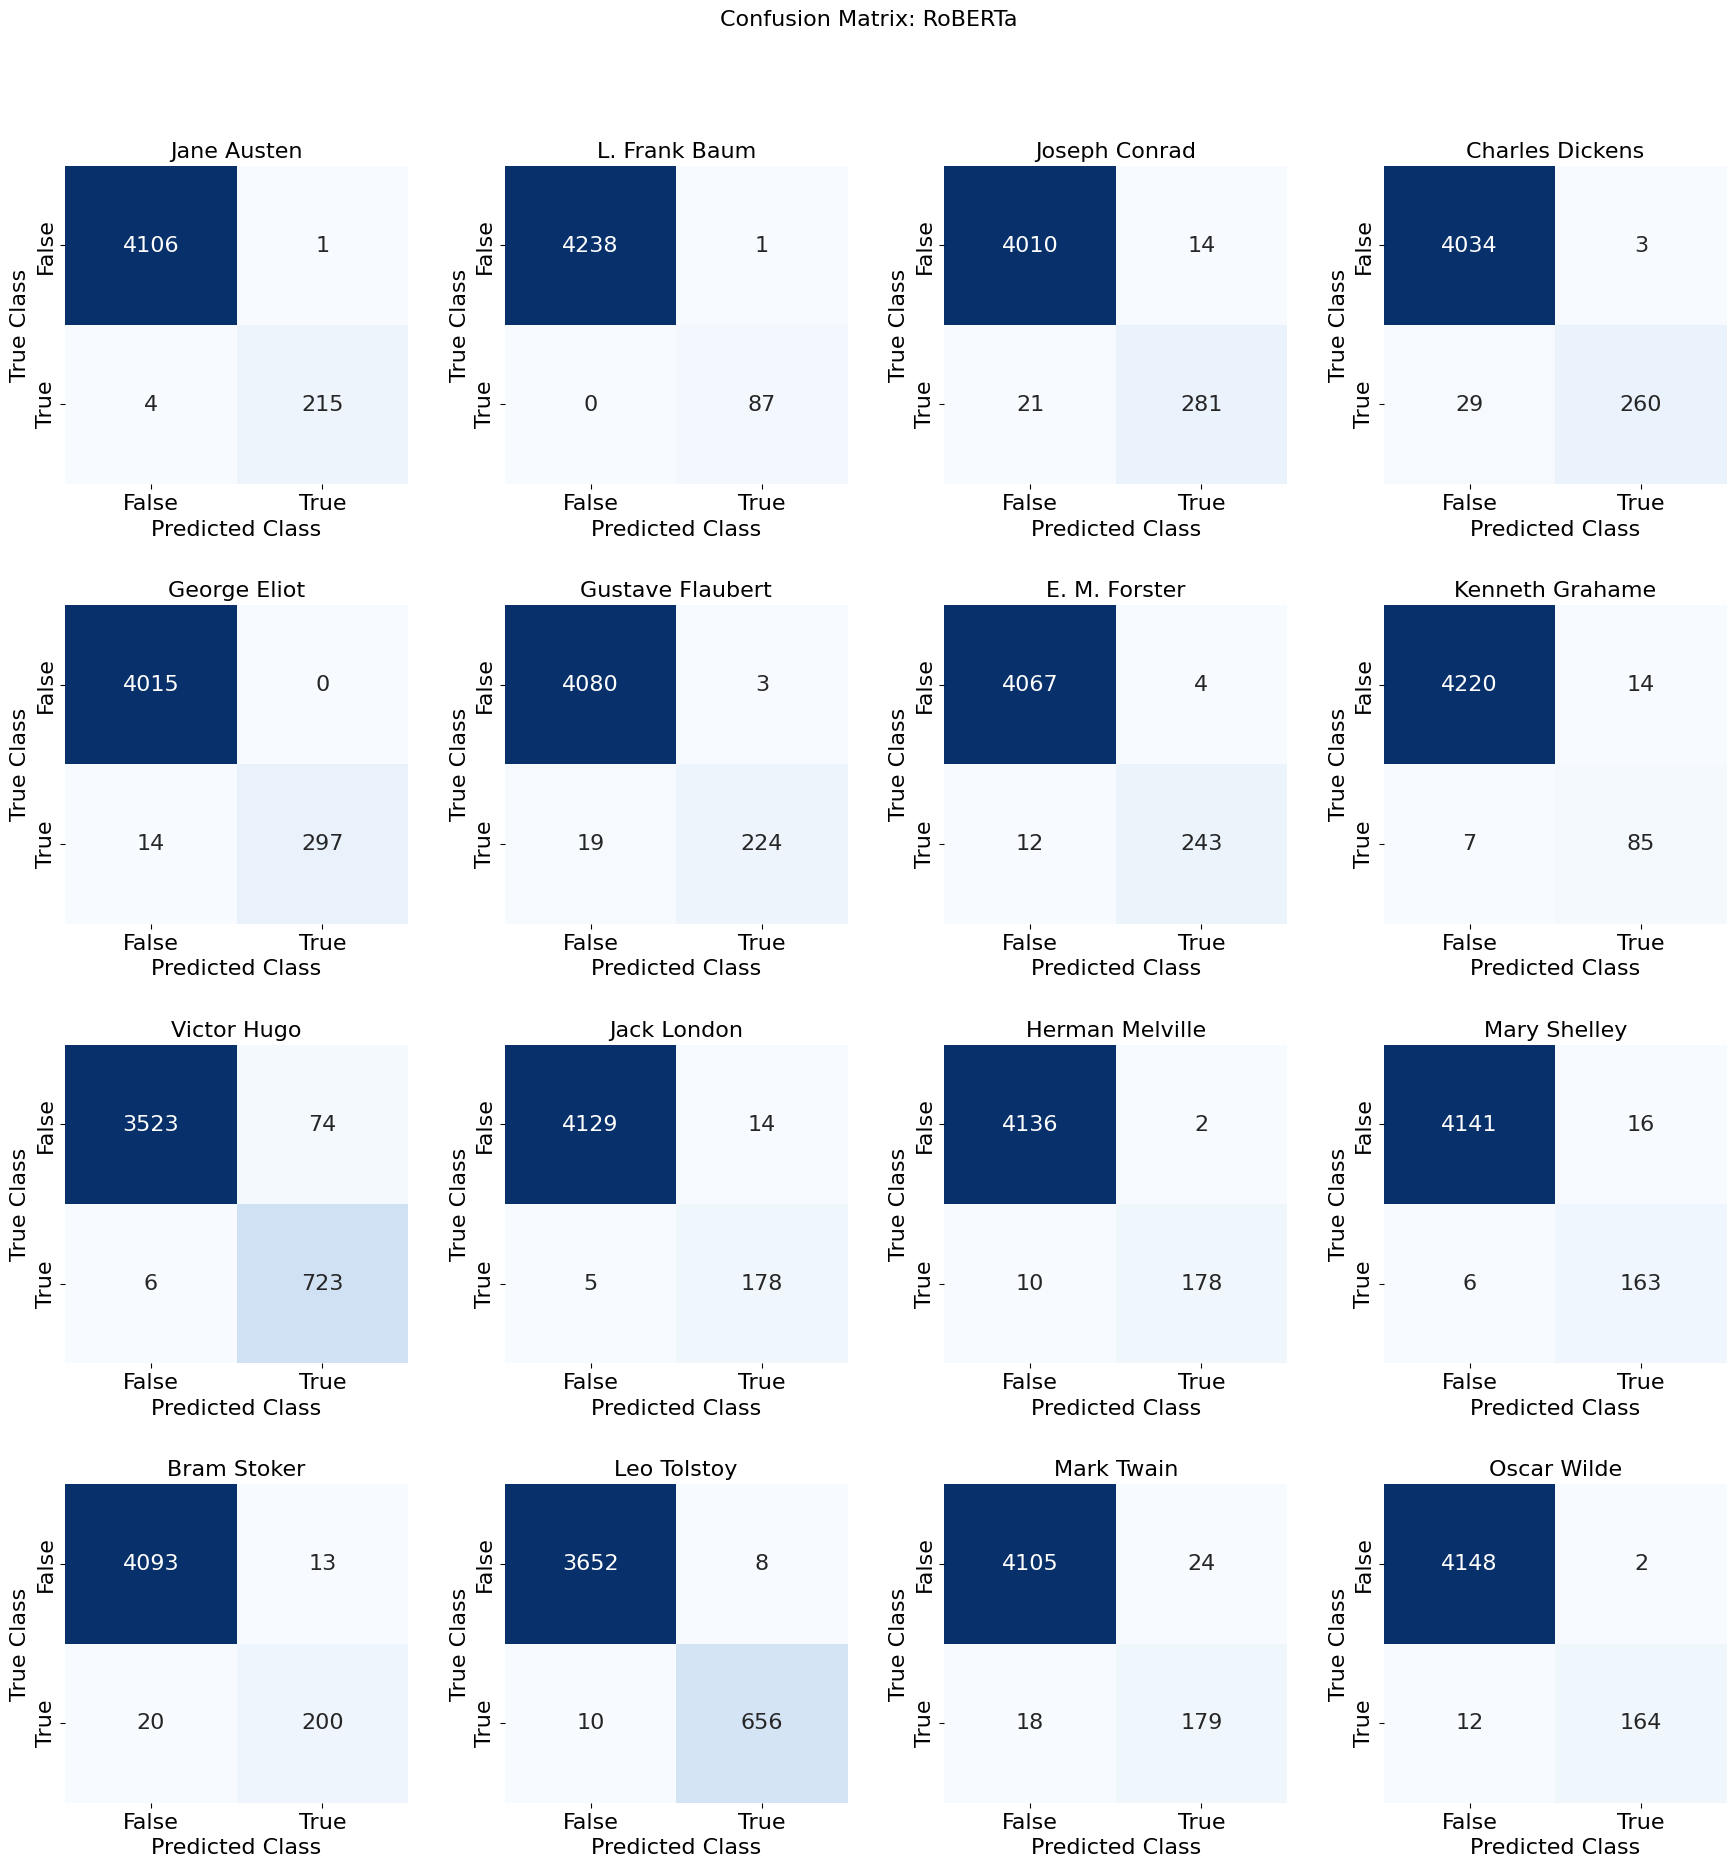

In [29]:
mcm = multilabel_confusion_matrix(test_labels, one_hot_predictions)
label_to_author = dict(zip(authors['AuthorCode'], authors['Author']))
total_labels = mcm.shape[0]

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(18, 18))
axes = axes.flatten()

for label_index in range(total_labels):
    author_name = label_to_author.get(label_index, f'Label: {label_index}')
    sns.heatmap(mcm[label_index], annot=True, fmt='d', cmap='Blues', ax=axes[label_index], cbar=False,
                annot_kws={"size": 16}, 
                xticklabels=['False', 'True'], yticklabels=['False', 'True'])
    axes[label_index].set_title(author_name, fontsize=16) # increase the title font size
    axes[label_index].set_xlabel('Predicted Class', fontsize=16) # increase the xlabel font size
    axes[label_index].set_ylabel('True Class', fontsize=16) # increase the ylabel font size
    axes[label_index].tick_params(axis='x', labelsize=16) # increase x tick label font size
    axes[label_index].tick_params(axis='y', labelsize=16) # increase y tick label font size

for i in range(total_labels, len(axes)):
    axes[i].axis('off')

plt.tight_layout(pad=3.0)
fig.suptitle('Confusion Matrix: RoBERTa', fontsize=16, y=1.05)
plt.savefig(f'{plots_dir}cm_16_all2.pdf', bbox_inches='tight')
plt.show()

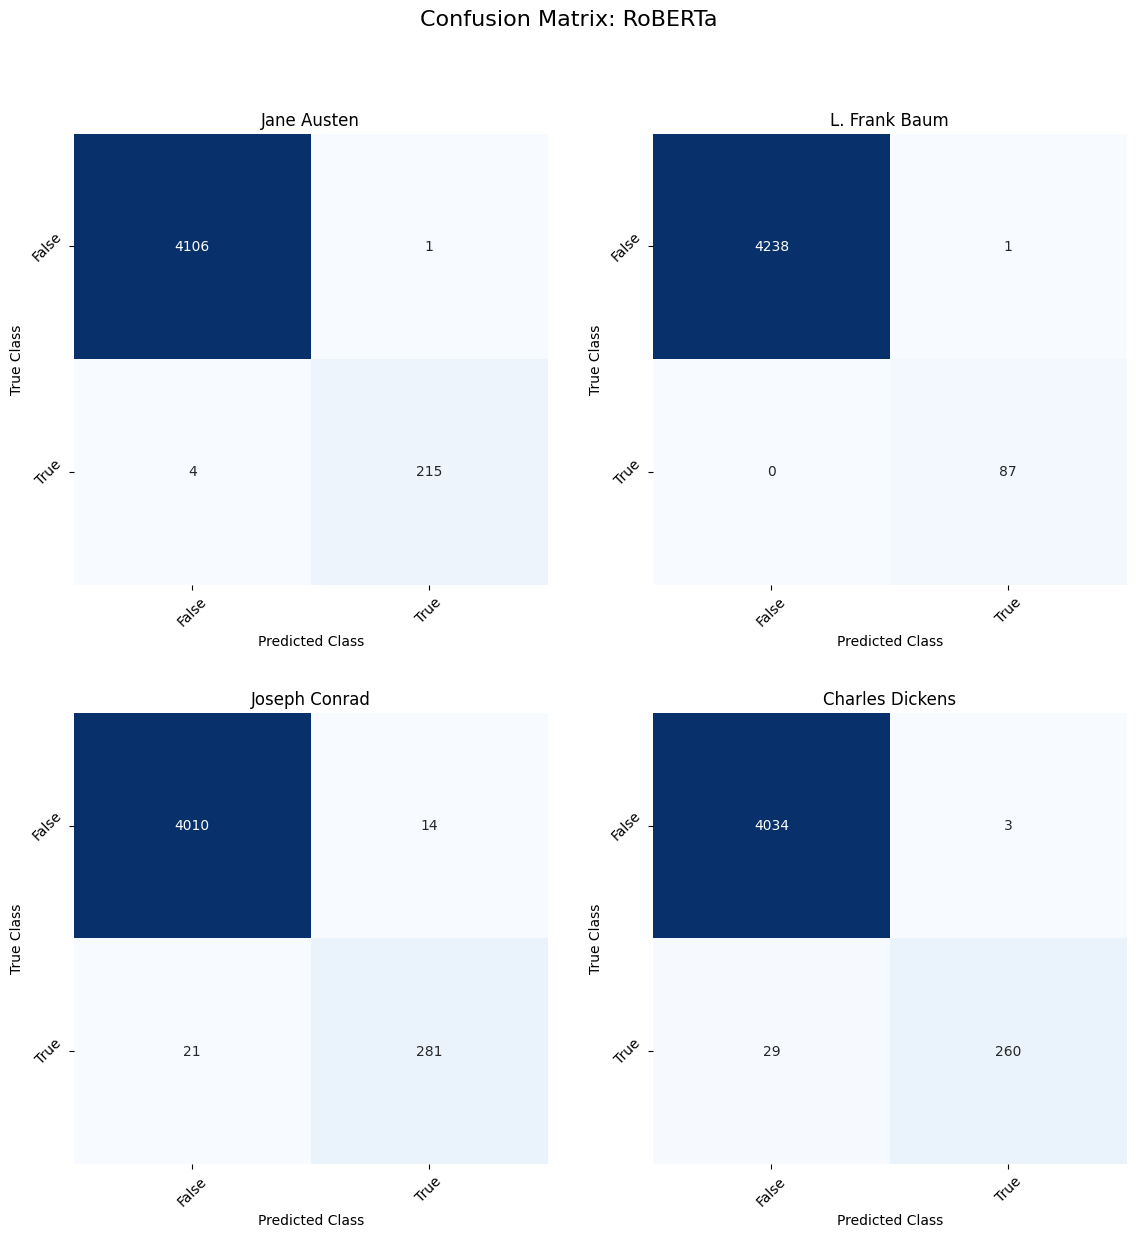

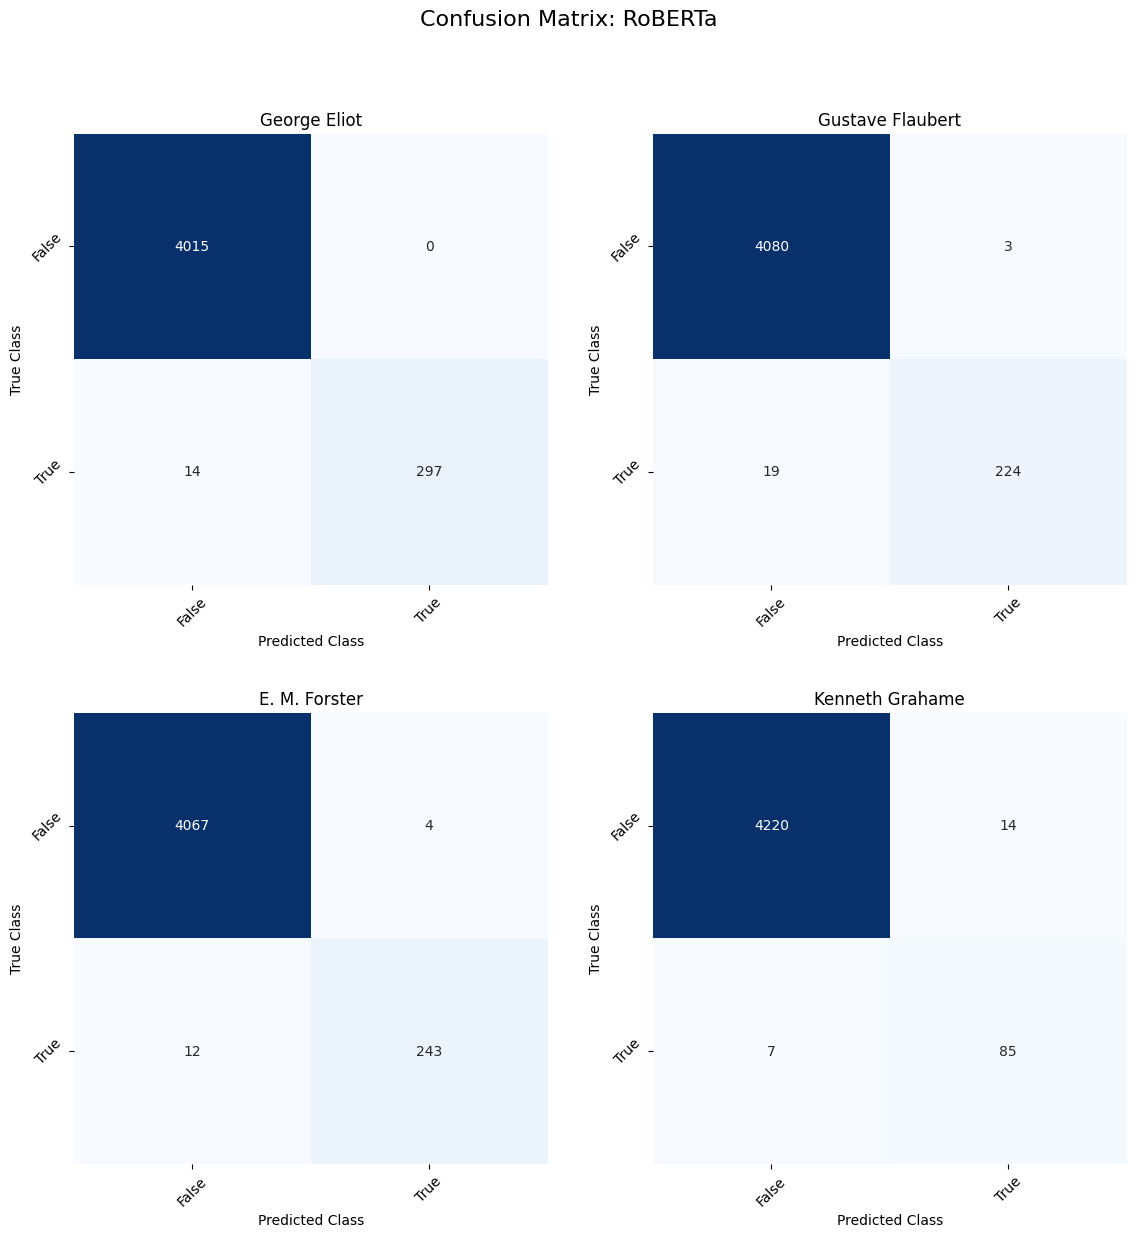

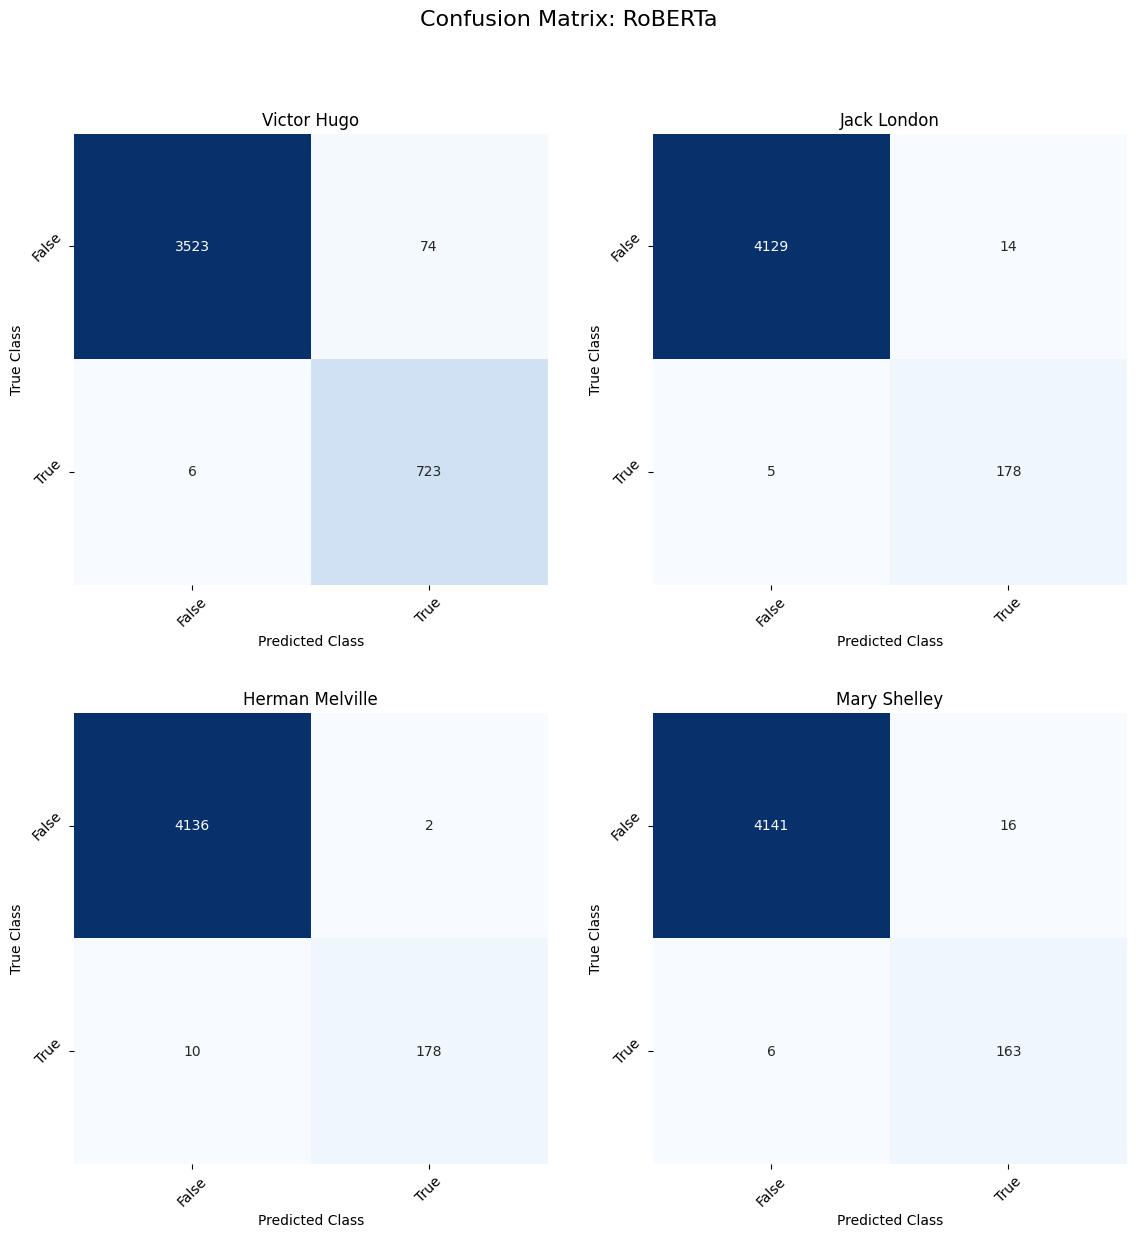

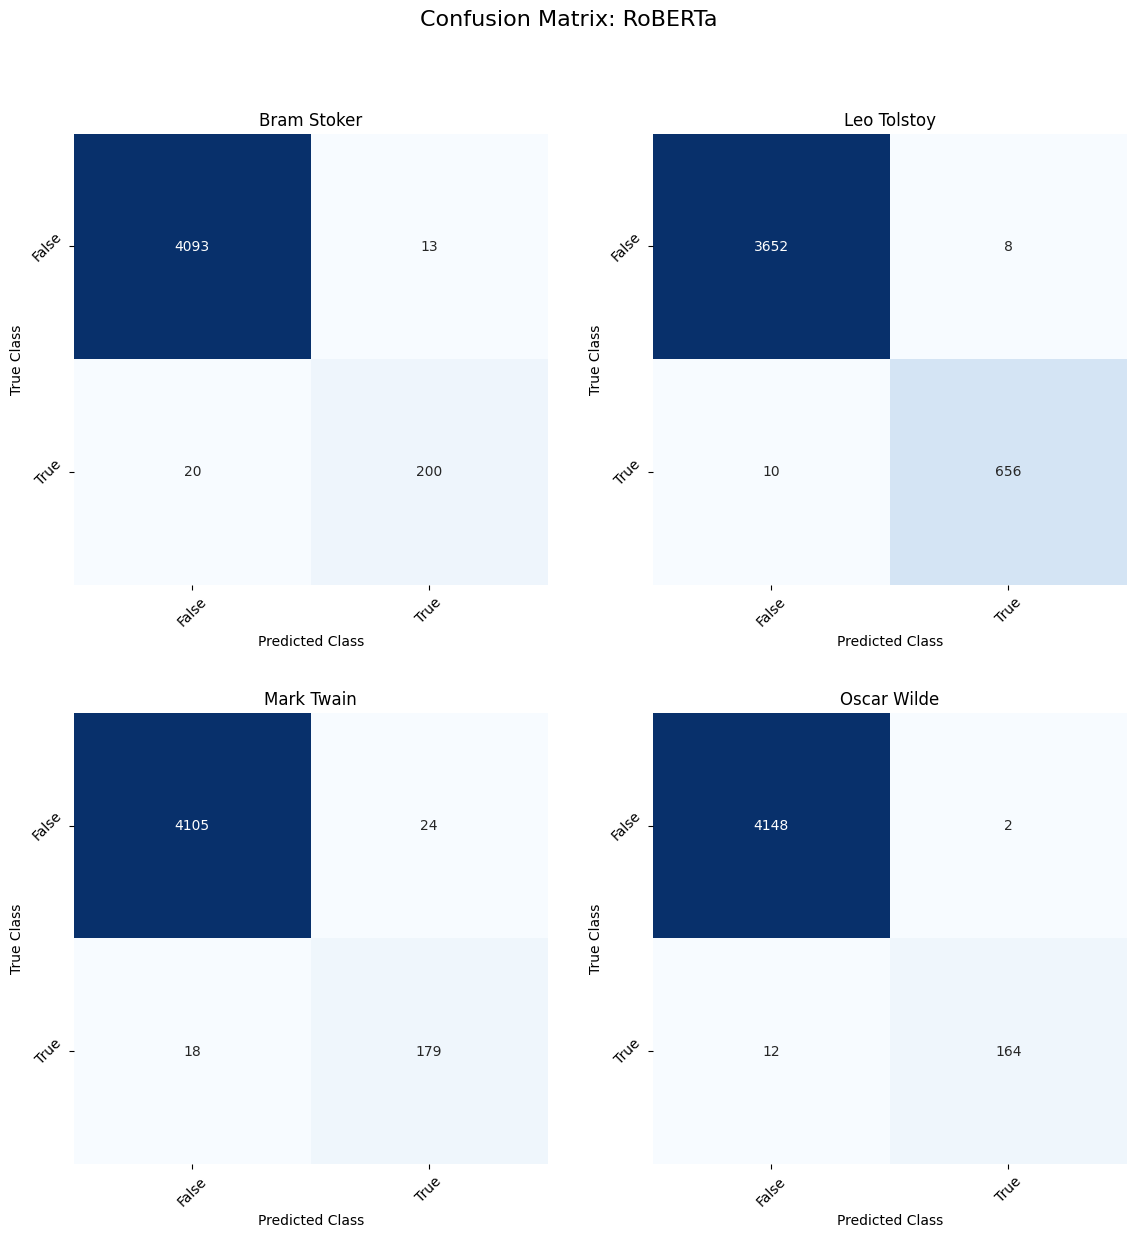

In [30]:
mcm = multilabel_confusion_matrix(test_labels, one_hot_predictions)
label_to_author = dict(zip(authors['AuthorCode'], authors['Author']))

total_labels = mcm.shape[0]

num_figures = total_labels // 4

for fig_index in range(num_figures):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
    axes = axes.flatten()

    for i in range(4):
        label_index = fig_index * 4 + i
        if label_index < total_labels:
            author_name = label_to_author.get(label_index, f'Label: {label_index}')
            sns.heatmap(mcm[label_index], annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False)
            axes[i].set_title(author_name)
            axes[i].set_xlabel('Predicted Class')
            axes[i].set_ylabel('True Class')
            axes[i].set_xticklabels(['False', 'True'], rotation=45)
            axes[i].set_yticklabels(['False', 'True'], rotation=45)
        else:
            axes[i].axis('off')

    plt.tight_layout(pad=3.0)
    fig.suptitle(f'Confusion Matrix: RoBERTa', fontsize=16, y=1.05)
    plt.savefig(f'{plots_dir}cm_16_class_RoBERTa_figure_{fig_index+1}.pdf', bbox_inches='tight')
    plt.show()

In [31]:
predictions = trainer.predict(test_dataset)
print(predictions.metrics)

{'test_loss': 0.028786063194274902, 'test_accuracy': 0.9553860379103097, 'test_recall': 0.9484861106320207, 'test_precision': 0.9552937904162521, 'test_f1': 0.9512461643721251, 'test_runtime': 23.9324, 'test_samples_per_second': 180.759, 'test_steps_per_second': 7.563}


In [32]:
accuracy = predictions.metrics['test_accuracy']
recall = predictions.metrics['test_recall']
f1 = predictions.metrics['test_f1']
precision = predictions.metrics['test_precision']

In [33]:
probabilities = softmax(test_results.predictions, axis=1)


fpr, tpr, roc_auc = {}, {}, {}
n_classes = test_labels.shape[1]

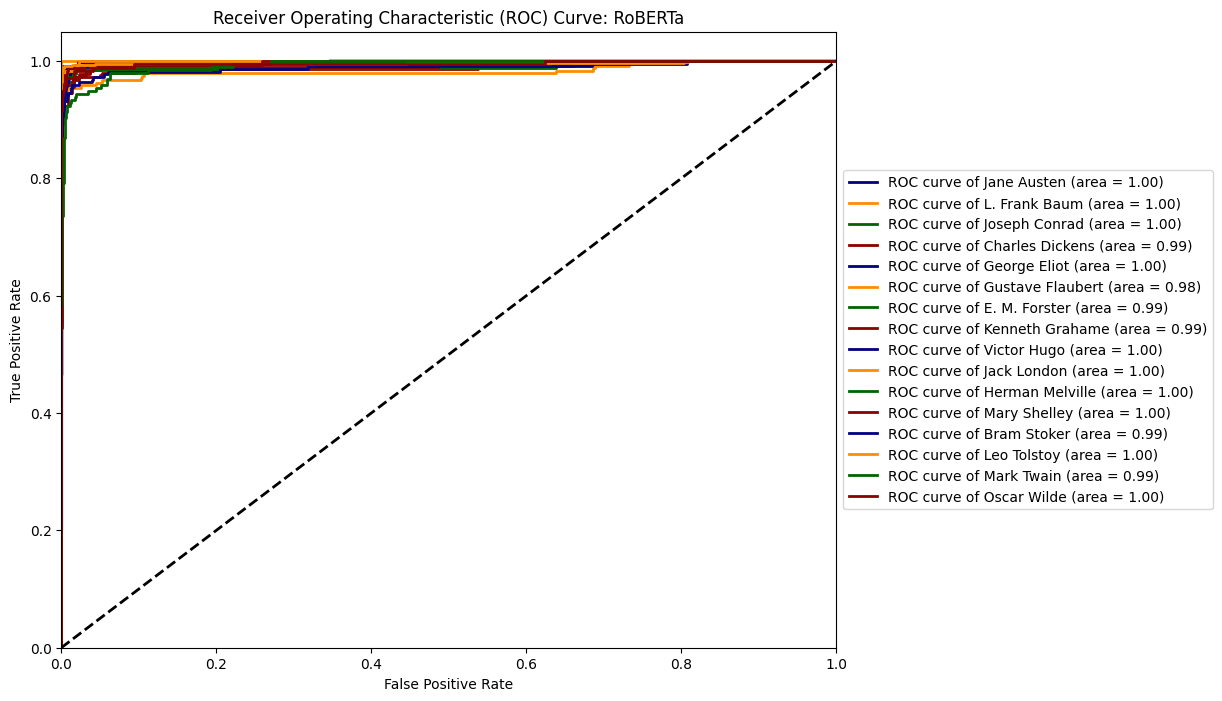

In [34]:
author_map = dict(zip(authors['AuthorCode'], authors['Author']))
from itertools import cycle

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


colors = cycle(['navy', 'darkorange', 'darkgreen', 'darkred'])
plt.figure(figsize=(10, 8))

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {author_map.get(i, f"Class {i}")} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve: RoBERTa')


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig(f'{plots_dir}roc_16_class_RoBERTa.pdf', bbox_inches='tight')
plt.show()

In [35]:
metrics_data = {'Accuracy': [accuracy], 'Precision': [precision], 'F1-Score': [f1], 'Recall': [recall ]}
metrics_df = pd.DataFrame(metrics_data)

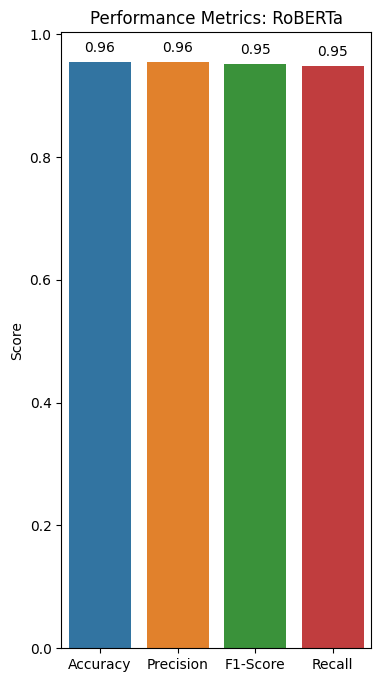

In [36]:
plt.figure(figsize=(4, 8))
ax = sns.barplot(data=metrics_df)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),  
                (p.get_x() + p.get_width() / 2., p.get_height()),  
                ha = 'center',  
                va = 'center',  
                xytext = (0, 10),  
                textcoords = 'offset points')
plt.title('Performance Metrics: RoBERTa')
plt.ylabel('Score')
plt.savefig(f'{plots_dir}performance_16_class_RoBERTa.pdf', bbox_inches='tight')
plt.show()

In [37]:
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print('Precision: ', precision)

Accuracy: 0.9553860379103097
Recall: 0.9484861106320207
F1 Score: 0.9512461643721251
Precision:  0.9552937904162521
